In [1]:
# Data Processing & Analysis
import pandas as pd              # Data manipulation (DataFrames, Series)
import numpy as np               # Numerical operations (arrays, math functions)
from collections import Counter  # Count hashable objects (for frequency analysis)
import ast                       # Safely evaluate strings as Python literals (for list columns)

# Visualization Libraries (Static)
import matplotlib as mpl         # Base matplotlib library (configuration)
import matplotlib.pyplot as plt  # MATLAB-style plotting interface
from matplotlib.cm import ScalarMappable  # Color mapping for visualizations
from matplotlib.lines import Line2D       # Custom legend handles
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  # Embedded axes
import seaborn as sns            # High-level statistical visualization

# Visualization Libraries (Interactive)
import plotly.express as px      # Simple interactive visualizations
import dash                      # Web dashboard framework
from dash import dcc, html       # Dash core components & HTML tags
from dash.dependencies import Input, Output  # Callback functionality

# Text & Image Processing
from textwrap import wrap        # Text formatting for labels
from wordcloud import WordCloud, ImageColorGenerator  # Generate word clouds
from PIL import Image            # Image processing (for custom word cloud masks)

In [2]:
# Let's import and see our data:
df = pd.read_csv("../Data/anime_data.csv")
df.head()

,title,genres,episodes,duration_per_episode,score,year,studios,Q_views
0,Dragon Ball,"['Action', 'Adventure', 'Comedy', 'Fantasy']",153,24 min per ep,7.98,1986.0,['Toei Animation'],1
1,Pokemon,"['Action', 'Adventure', 'Comedy', 'Fantasy']",276,24 min per ep,7.41,1997.0,['OLM'],1
2,Bishoujo Senshi Sailor Moon,['Romance'],46,24 min per ep,7.74,1992.0,['Toei Animation'],1
3,InuYasha,"['Action', 'Adventure', 'Fantasy', 'Romance']",167,24 min per ep,7.87,2000.0,['Sunrise'],7
4,Death Note,"['Supernatural', 'Suspense']",37,23 min per ep,8.62,2006.0,['Madhouse'],2


In [3]:
# Function to convert duration_per_episode to just minutes (numbers)
# - Handles two formats: 
#   1. "X hr Y min" → converts to (X*60 + Y) minutes
#   2. "Z min per ep" → extracts Z as minutes
def convert_to_minutes(duration):
    if 'hr' in duration:
        # Extract hours and minutes (e.g., "1 hr 30 min" → 90 min)
        parts = duration.split()
        hours = int(parts[0])
        minutes = int(parts[2]) if 'min' in parts[3] else 0
        return hours * 60 + minutes
    else:
        # Extract just minutes (e.g., "73 min per ep" → 73)
        return int(duration.split()[0])

# Apply the function to create a new column
df['minutes_per_episode'] = df['duration_per_episode'].apply(convert_to_minutes)

In [4]:
# Display the data types of each column in the DataFrame
# - Helps identify how pandas has interpreted each column (e.g., numeric, string, object)
# - Critical for ensuring correct analysis (e.g., numbers stored as strings won't work in math operations)
df.dtypes

title                    object
genres                   object
episodes                  int64
duration_per_episode     object
score                   float64
year                    float64
studios                  object
Q_views                   int64
minutes_per_episode       int64
dtype: object

In [5]:
# 1. Clean 'title' column (convert to efficient string dtype)
df['title'] = df['title'].str.strip().astype('string')  # Uses pandas' StringDtype (more efficient than object)

# 2. Convert string representations of lists to actual lists
for list_col in ['genres', 'studios']:
    df[list_col] = df[list_col].apply(
        lambda x: ast.literal_eval(x) if pd.notna(x) and x.startswith('[') else []
    )
    # Added safety check for malformed strings

# 3. Numeric conversions with better error handling
numeric_cols = {
    'episodes': 'Int64',    # Nullable integer type
    'score': 'float64',     # Standard float
    'year': 'Int64',        # Nullable integer type
    'Q_views': 'Int64'      # Added this conversion as it wasn't in original
}

for col, dtype in numeric_cols.items():
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(dtype)

# Verify conversions
print("\n=== Data Types After Conversion ===")
print(df.dtypes)

# Additional validation
print("\n=== Missing Values After Conversion ===")
print(df.isna().sum())


=== Data Types After Conversion ===
title                   string[python]
genres                          object
episodes                         Int64
duration_per_episode            object
score                          float64
year                             Int64
studios                         object
Q_views                          Int64
minutes_per_episode              int64
dtype: object

=== Missing Values After Conversion ===
title                   0
genres                  0
episodes                0
duration_per_episode    0
score                   0
year                    5
studios                 0
Q_views                 0
minutes_per_episode     0
dtype: int64


In [6]:
# Summary of key Statistics
print("=== Key Statistics ===")
print(f"Total anime watched: {len(df)}")
print(f"Average episode duration: {df['minutes_per_episode'].mean():.1f} minutes")
print(f"Average score: {df['score'].mean():.2f}")
print(f"Missing years: {df['year'].isna().sum()}")

=== Key Statistics ===
Total anime watched: 58
Average episode duration: 28.7 minutes
Average score: 7.86
Missing years: 5



Anime with missing year:
                                        title             studios
7   Hunter x Hunter Movie 2: The Last Mission          [Madhouse]
8      Hunter x Hunter Movie 1: Phantom Rouge          [Madhouse]
13                     Evangelion: 3.0 (-46h)             [Khara]
22                             Koe no Katachi   [Kyoto Animation]
23                             Kimi no Na wa.  [CoMix Wave Films]


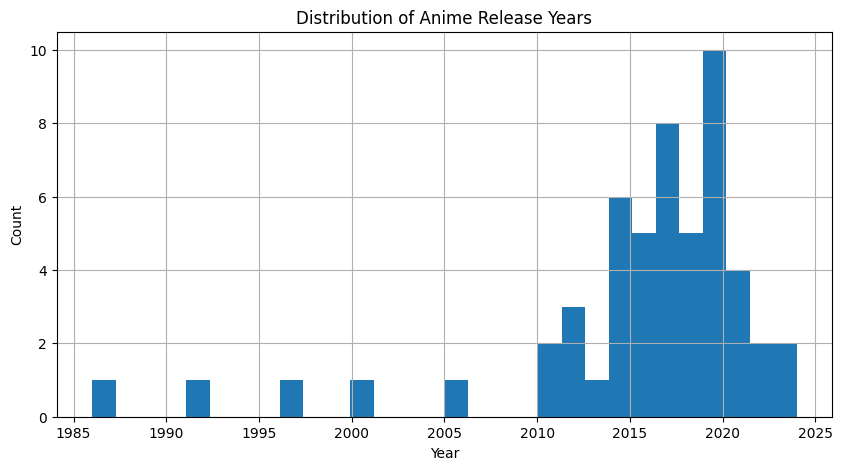

In [7]:
# Year Analyisis
# Identify anime with missing year
missing_year = df[df['year'].isna()][['title', 'studios']]
print("\nAnime with missing year:")
print(missing_year)

# Year distribution visualization
plt.figure(figsize=(10,5))
df['year'].dropna().astype(int).hist(bins=30)
plt.title('Distribution of Anime Release Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


Score Distribution:
count    58.000000
mean      7.859828
std       0.609865
min       6.120000
25%       7.420000
50%       7.885000
75%       8.297500
90%       8.578000
max       9.030000
Name: score, dtype: float64


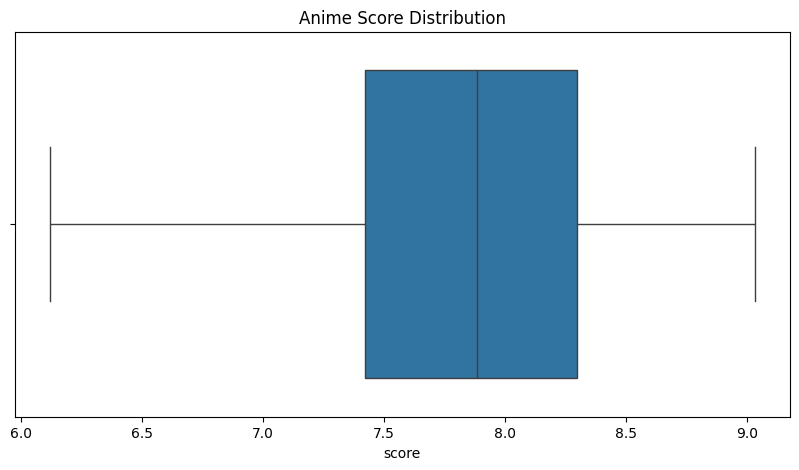

In [8]:
# Score Analysis
print("\nScore Distribution:")
print(df['score'].describe(percentiles=[.25, .5, .75, .9]))

# Visualize score distribution
plt.figure(figsize=(10,5))
sns.boxplot(x=df['score'])
plt.title('Anime Score Distribution')
plt.show()

In [9]:
# Breakdown of duration types
duration_types = df['duration_per_episode'].str.contains('hr').value_counts()
print("\nDuration Types:")
print(f"Standard episodes: {duration_types.get(False, 0)}")
print(f"Movies/specials: {duration_types.get(True, 0)}")


Duration Types:
Standard episodes: 54
Movies/specials: 4


In [10]:
# Missing Values (years) :
# Fill missing years from external data or reasonable estimates
df.loc[df['title'] == "Hunter x Hunter Movie 2: The Last Mission", 'year'] = 2013
df.loc[df['title'] == "Hunter x Hunter Movie 1: Phantom Rouge", 'year'] = 2013
df.loc[df['title'] == "Evangelion: 3.0 (-46h)", 'year'] = 2021
df.loc[df['title'] == "Koe no Katachi", 'year'] = 2016
df.loc[df['title'] == "Kimi no Na wa.", 'year'] = 2018

In [11]:
# Genre frequency (after your list conversion)
all_genres = df['genres'].explode()
print("\nMost Common Genres:")
print(all_genres.value_counts().head(5))

# Studio analysis
all_studios = df['studios'].explode()
print("\nMost Productive Studios:")
print(all_studios.value_counts().head(5))


Most Common Genres:
genres
Action       23
Romance      22
Drama        19
Fantasy      16
Adventure    11
Name: count, dtype: int64

Most Productive Studios:
studios
A-1 Pictures      5
MAPPA             5
Madhouse          4
Production I.G    4
CloverWorks       4
Name: count, dtype: int64


In [12]:
# Explode genres while preserving other list-type columns
df_exploded = df.explode('genres')
df_exploded.head()
df_exploded.to_csv("../Data/df_exploded.csv", index=False)

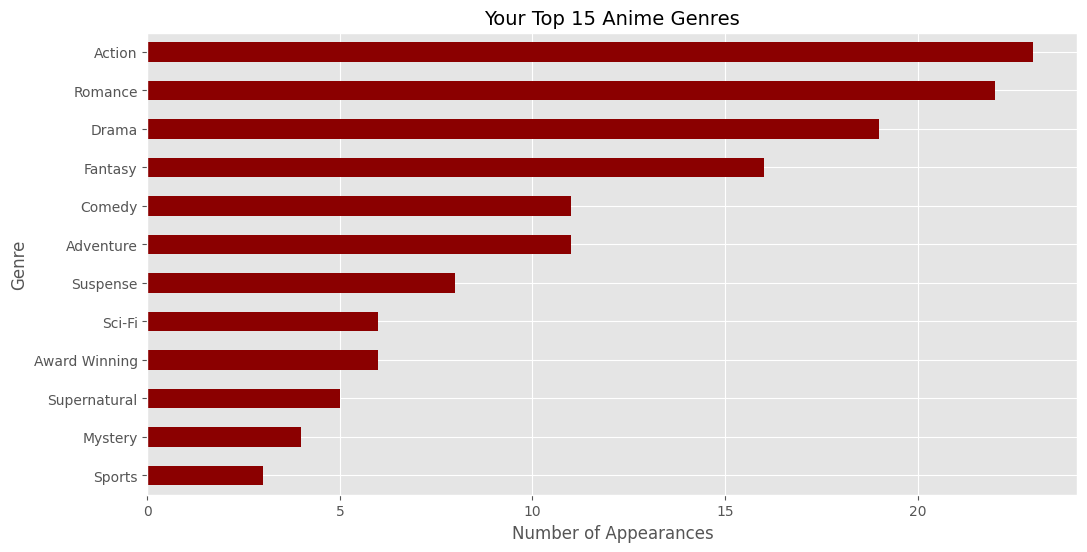

In [13]:
plt.style.use('ggplot')

# Genre Frequency Analysis
genre_counts = df_exploded['genres'].value_counts()

plt.figure(figsize=(12,6))
genre_counts.head(15).sort_values().plot.barh(color='darkred')
plt.title('Your Top 15 Anime Genres', fontsize=14)
plt.xlabel('Number of Appearances')
plt.ylabel('Genre')
plt.show()

In [14]:
# Explode studios
studio_genre = df_exploded.explode('studios')

# Top studio-genre combinations
top_combos = (
    studio_genre.groupby(['studios', 'genres'])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

print("\n=== Favorite Studio-Genre Combinations ===")
print(top_combos)


=== Favorite Studio-Genre Combinations ===
studios          genres   
Madhouse         Action       3
MAPPA            Action       3
CloverWorks      Romance      3
A-1 Pictures     Romance      3
Madhouse         Fantasy      3
                 Adventure    3
MAPPA            Drama        2
Kyoto Animation  Drama        2
Project No.9     Drama        2
MAPPA            Adventure    2
dtype: int64


In [1]:
# Interactive Visualization of Animes
title_by_genre = px.sunburst(df_exploded, path=['genres', 'title'], values='score')
title_by_genre.write_html("../Outputs/circular_plot_titles.html") 

NameError: name 'px' is not defined

In [16]:
# Calculate total watch time in hours
df["total_watch_minutes"] = (
    df["minutes_per_episode"].fillna(0) * 
    df["episodes"].fillna(1) *  # Assume 1 episode if missing
    df["Q_views"].fillna(1)     # Assume 1 viewing if missing
)

total_hours = df["total_watch_minutes"].sum() / 60
total_days = total_hours / 24

print("=== Anime Watch Time ===")
print(f"Total hours: {total_hours:,.2f}")
print(f"That's approximately {total_days:,.1f} full days!")
print(f"Equivalent to {total_hours/24/365:,.2f} years of non-stop watching")
print(f"Equivalent to watching 'One Piece' {total_hours/1000:,.1f} times")  # Assuming 1000 eps at 24 mins

=== Anime Watch Time ===
Total hours: 1,288.88
That's approximately 53.7 full days!
Equivalent to 0.15 years of non-stop watching
Equivalent to watching 'One Piece' 1.3 times


In [17]:
# Average time per anime
print(f"\nAverage time per anime: {df['total_watch_minutes'].mean()/60:,.1f} hours")

# Time distribution by genre
genre_time = (
    df.explode('genres')
    .groupby('genres')['total_watch_minutes']
    .sum()
    .sort_values(ascending=False))
    
print("\nTop 5 Genres by Watch Time:")
print((genre_time.head(5)/60).apply(lambda x: f"{x:,.1f} hours"))


Average time per anime: 22.2 hours

Top 5 Genres by Watch Time:
genres
Action       946.1 hours
Fantasy      855.1 hours
Adventure    843.7 hours
Romance      651.6 hours
Comedy       247.3 hours
Name: total_watch_minutes, dtype: object


In [18]:
df_exploded.head()

,title,genres,episodes,duration_per_episode,score,year,studios,Q_views,minutes_per_episode
0,Dragon Ball,Action,153,24 min per ep,7.98,1986,[Toei Animation],1,24
0,Dragon Ball,Adventure,153,24 min per ep,7.98,1986,[Toei Animation],1,24
0,Dragon Ball,Comedy,153,24 min per ep,7.98,1986,[Toei Animation],1,24
0,Dragon Ball,Fantasy,153,24 min per ep,7.98,1986,[Toei Animation],1,24
1,Pokemon,Action,276,24 min per ep,7.41,1997,[OLM],1,24


In [19]:
# Calculate comprehensive genre statistics
# Calculate total watch time in hours
df_exploded["total_watch_minutes"] = (
    df["minutes_per_episode"].fillna(0) * 
    df["episodes"].fillna(1) *  # Assume 1 episode if missing
    df["Q_views"].fillna(1)     # Assume 1 viewing if missing
)
genre_stats = (
    df_exploded.groupby('genres')
    .agg(
        Number_of_Titles=('title', 'count'),
        Total_Hours=('total_watch_minutes', lambda x: x.sum()/60),
        Average_Score=('score', 'mean'),
        Most_Watched_Title=('title', lambda x: (df_exploded.loc[x.index]
                                              .groupby('title')['Q_views']
                                              .sum()
                                              .idxmax()))
    )
    .sort_values('Total_Hours', ascending=False)
    .reset_index()
)

# Formatting for readability
genre_stats['Total_Hours'] = genre_stats['Total_Hours'].round(1)
genre_stats['Average_Score'] = genre_stats['Average_Score'].round(2)

print("=== Comprehensive Genre Statistics ===")
display(genre_stats.head(10))

=== Comprehensive Genre Statistics ===


,genres,Number_of_Titles,Total_Hours,Average_Score,Most_Watched_Title
0,Action,23,946.1,7.75,InuYasha
1,Fantasy,16,855.1,7.57,InuYasha
2,Adventure,11,843.7,7.69,InuYasha
3,Romance,22,651.6,7.71,InuYasha
4,Comedy,11,247.3,7.83,Dr. Stone
5,Drama,19,197.0,7.97,Banana Fish
6,Suspense,8,115.2,8.23,Banana Fish
7,Supernatural,5,76.4,8.42,Seishun Buta Yarou wa Bunny Girl Senpai no Yum...
8,Award Winning,6,71.8,8.53,Shingeki no Kyojin
9,Sports,3,63.0,8.17,Yuri!!! on Ice


In [20]:
# Interactive plot to see the consumption of every genre in hours and number of titles.

colorscale = [
[0, 'rgb(38, 53, 113)'], 
[0.5, 'rgb(57, 162, 225)'],
[1, 'rgb(234, 32, 41)']
]

plot_genre = px.bar_polar(
    genre_stats, 
    r="Total_Hours",
    theta="genres",
    color="Number_of_Titles",
    template="plotly_white",
   color_continuous_scale= colorscale
)
plot_genre.show()
plot_genre.write_html("../Outputs/circular_plot_genre.html") 

In [21]:
# making cleaning to make a wordcloud
text = ' '.join(genre for sublist in df['genres'] for genre in sublist).replace('-','')
print(text)

Action Adventure Comedy Fantasy Action Adventure Comedy Fantasy Romance Action Adventure Fantasy Romance Supernatural Suspense Drama Mystery Suspense Action Adventure Fantasy Action Adventure Fantasy Action Adventure Fantasy Action Award Winning Drama Suspense Mystery Suspense Action Award Winning Supernatural Action Adventure Fantasy SciFi Action Adventure Comedy SciFi Action Award Winning Supernatural Drama Romance Comedy Romance Romance Drama Romance Supernatural Comedy Romance Award Winning Drama Award Winning Drama Drama Suspense Drama Fantasy Romance Action Comedy Fantasy Drama Comedy Romance Comedy Romance Action Adventure Fantasy Action Adventure Fantasy Action Fantasy Action Fantasy Drama Action Fantasy Drama Supernatural Drama Romance Drama Romance Romance Comedy Romance Drama Romance Sports Action Fantasy SciFi Action Fantasy SciFi Action Mystery SciFi Suspense Drama Romance Award Winning Sports Action Adventure Drama Suspense Drama Romance SciFi Drama Romance Drama Romance 

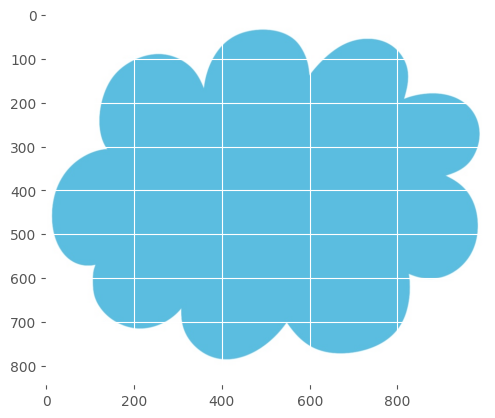

In [22]:
background_image = np.array(Image.open('../Ilustración_sin_título.jpg'))
plt.imshow(background_image)

In [23]:
word_cloud1 = WordCloud(collocations = False, 
                        mask = background_image, 
                        background_color = 'white',
                        font_path = "../../../Downloads/DynaPuff/DynaPuff-VariableFont_wdth,wght.ttf",
                        colormap = "PiYG_r",
                        width = 2048, 
                        height = 1080).generate(text)
# saving the image
word_cloud1.to_file('../Outputs/wcan.png')

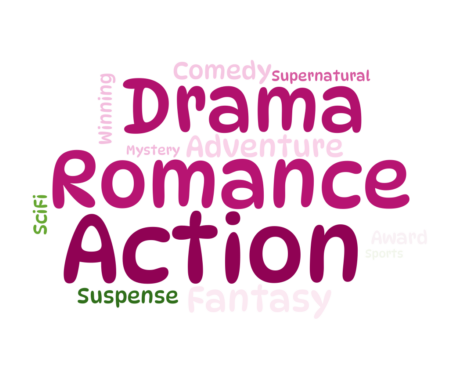

In [24]:
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
# Prepare data with better column names
data = pd.DataFrame({
    'Genre': df_exploded["genres"],
    'Year': df_exploded["year"],
    'Score': df_exploded["score"],
    'Episodes': df_exploded["episodes"],
    'Title': df_exploded["title"],
    'WatchTime': df_exploded["total_watch_minutes"]
})

# Initialize Dash app with meta tags for mobile responsiveness
app = dash.Dash(__name__, meta_tags=[
    {"name": "viewport", "content": "width=device-width, initial-scale=1.0"}
])

app.layout = html.Div([
    html.H1("Anime Genre Explorer", style={'textAlign': 'center'}),
    
    html.Div([
        dcc.Dropdown(
            id='genre-filter',
            options=[{'label': genre, 'value': genre} 
                    for genre in sorted(data['Genre'].unique())],
            value='Action',  # Default to most common genre
            clearable=False,
            style={'width': '50%', 'margin': 'auto'}
        ),
    ], style={'padding': '20px'}),
    
    dcc.Graph(id='bubble-chart', style={'height': '80vh'}),
    
    html.Div([
        html.P("Hover over bubbles for details. Size represents episode count, color shows watch time."),
        html.P("Tip: Try zooming and panning on the chart!")
    ], style={'textAlign': 'center', 'color': 'gray'})
])

@app.callback(
    Output('bubble-chart', 'figure'),
    Input('genre-filter', 'value')
)
def update_graph(selected_genre):
    filtered_df = data[data['Genre'] == selected_genre]
    
    fig = px.scatter(
        filtered_df,
        x='Year',
        y='Score',
        size='Episodes',
        color='WatchTime',
        hover_name='Title',
        hover_data={
            'Year': True,
            'Score': ':.2f',
            'Episodes': True,
            'WatchTime': ':.1f hours',
            'Genre': False  # Hide redundant genre info
        },
        title=f'{selected_genre} Anime: Score vs Year',
        size_max=40,
        color_continuous_scale=px.colors.sequential.Viridis,
        labels={
            'Year': 'Release Year',
            'Score': 'MyAnimeList Score',
            'Episodes': 'Episode Count',
            'WatchTime': 'Hours Watched'
        }
    )
    
    # Enhance layout
    fig.update_layout(
        transition_duration=500,
        xaxis_range=[filtered_df['Year'].min()-2, filtered_df['Year'].max()+2],
        yaxis_range=[filtered_df['Score'].min()-0.5, 10],  # MAL scores cap at 10
        plot_bgcolor='rgba(240,240,240,0.8)'
    )
    
    # Add reference lines
    fig.add_hline(y=7.5, line_dash="dot", 
                 annotation_text="Good Anime", 
                 annotation_position="bottom right")
    fig.add_hline(y=8.5, line_dash="dot", 
                 annotation_text="Great Anime", 
                 annotation_position="top right")
    
    return fig

if __name__ == '__main__':
    app.run(debug=True, dev_tools_ui=True)



In [26]:
# Recomendations
def recommend_anime(genre, max_episodes=50):
    return df[
        (df['genres'].str.contains(genre)) & 
        (df['episodes'] <= max_episodes) &
        (df['score'] > 8)
    ].sort_values('score', ascending=False)

# Example:
recommend_anime('Fantasy').head(3)[['title', 'score', 'studios']]

,title,score,studios
22,Koe no Katachi,8.93,[Kyoto Animation]
23,Kimi no Na wa.,8.83,[CoMix Wave Films]
27,Violet Evergarden,8.68,[Kyoto Animation]
